**Use Resnet 50+ Cutmix on Toys Department with image size resized to median height(229) and median width(213) along with ring loss** 

In [1]:
!nvidia-smi

Mon Jul 20 16:09:43 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.39       Driver Version: 418.39       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN RTX           Off  | 00000000:04:00.0 Off |                  N/A |
| 41%   49C    P2   123W / 280W |  18631MiB / 24190MiB |     63%      Default |
+-------------------------------+----------------------+----------------------+
|   1  TITAN RTX           Off  | 00000000:05:00.0 Off |                  N/A |
| 64%   81C    P2   142W / 280W |  18631MiB / 24190MiB |     65%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [2]:
######### IMPORTING NECESSARY MODULES #########
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, TensorDataset
import sys
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data
from torchvision import transforms, datasets, models
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm


In [3]:
device = torch.device('cuda:4' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:4


**Dataloading Scheme**

In [4]:
trainlist = 'training_list_toys.txt'
validlist ='validation_list_toys.txt'


In [5]:
# Create a mapping of Unique product Ids to Labels(0 to 3713 classes)
# output = dictionary containing mapping of each upc to a label from (0 to 3713)  

with open(trainlist, mode = 'r') as f:
    
    Y=[]
    for line in f:
        path, UPC = line[:-1].split(',')

        Y.append(UPC)
        
prime_number_list = sorted(set(Y))

prime_number_dict = { prime_number_list[i] :i for i in range(0, len(prime_number_list) ) }

In [6]:
len(prime_number_dict)

3714

In [7]:
class mydataset():    

    def __init__(self, classification_list, prime_number_dict, name):

        super(mydataset).__init__()
        
        self.X = []
        self.Y = []
        
        with open(classification_list, mode = 'r') as f:
            
            for line in f:
                path, Prime_Number = line[:-1].split(',')

                self.X.append(path)
                self.Y.append(prime_number_dict[Prime_Number])
        

        if name == 'valid':
            self.transform = transforms.Compose([   transforms.RandomResizedCrop((229,213)),
                                                    transforms.ToTensor(),
                                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                    std=[0.229, 0.224, 0.225])
                                                ])
        else:
            self.transform = transforms.Compose([   transforms.RandomResizedCrop((229,213)),
                                                transforms.RandomHorizontalFlip(),
                                                transforms.ToTensor(),
                                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                    std=[0.229, 0.224, 0.225])
                                                                                            ])
    
    def __getitem__(self,index):
        
        image = self.X[index]        
        label = float(self.Y[index])
        
        image = (Image.open(image))
               
        image = self.transform(image)
        
        return image, torch.as_tensor(label).long()
        
  
    def __len__(self):
        return len(self.X)

In [8]:
# # #### Train Dataloader #### 
train_dataset = mydataset(trainlist, prime_number_dict, name='train')          
train_dataloader = data.DataLoader(train_dataset, shuffle= True, batch_size = 256, num_workers=16,pin_memory=True)


#### Validation Dataloader #### 
validation_dataset = mydataset(validlist, prime_number_dict, name='valid')         
validation_dataloader = data.DataLoader(validation_dataset, shuffle=True, batch_size = 128, num_workers=16,pin_memory=True)

**RESNET Architecture**

**Model Definition**

**Initialize the model**

In [10]:
model = ResNet(depth = 50, num_classes = 3714)
model = nn.DataParallel(model,device_ids=[4,5,6,7]).to(device)
model

DataParallel(
  (module): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

**Helper function for Cutmix
https://arxiv.org/pdf/1905.04899v2.pdf**

In [11]:
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

**Training Method**

In [12]:
def train(model, data_loader, test_loader,beta, cutmix_prob, epochs):
    model.train()

    for epoch in range(epochs):
        avg_loss = 0.0
                
        
        for batch_num, (feats, target) in enumerate(data_loader):
            feats, target = feats.to(device), target.to(device)
            
            
            r = np.random.rand(1)
            if beta > 0 and r < cutmix_prob:
                # generate mixed sample
                lam = np.random.beta(beta, beta)
                rand_index = torch.randperm(feats.size()[0]).to(device)
                target_a = target
                target_b = target[rand_index]
                bbx1, bby1, bbx2, bby2 = rand_bbox(feats.size(), lam)
                feats[:, :, bbx1:bbx2, bby1:bby2] = feats[rand_index, :, bbx1:bbx2, bby1:bby2]
                # adjust lambda to exactly match pixel ratio
                lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (feats.size()[-1] * feats.size()[-2]))
                # compute output
                output = model(feats)
                loss = criterion(output, target_a) * lam + criterion(output, target_b) * (1. - lam)
            else:
                # compute output
                output = model(feats)
                loss = criterion(output, target)
            
            output = output.to(device)
            ringloss = ringloss_block(output)
            
            total_loss = loss + ringloss
            
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()
            
            avg_loss += total_loss.item()

            if batch_num % 100 == 99:
                print('loss', avg_loss/100)

            del feats
            del target
            del loss

        lr_scheduler.step()

        print('Epoch: ', epoch+1)

        print('training loss = ', avg_loss/len(data_loader))
        train_loss.append(avg_loss/len(data_loader))

        ## Check performance on validation set after an Epoch
        valid_loss, top1_acc, top5_acc = test_classify(model, test_loader)
        print('Validation Loss: {:.4f}\tTop 1 Validation Accuracy: {:.4f}\t Top 5 Validation Accuracy: {:.4f}'.format(valid_loss, top1_acc, top5_acc))
        v_loss.append(valid_loss)
        v_acc.append(top1_acc)

    
        
        
        #########save model checkpoint #########
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'Training_Loss_List':train_loss,
            'Validation_Loss_List':v_loss,
            'Validation_Accuracy_List': v_acc,
            'Epoch':epoch,
            'lr_scheduler': lr_scheduler.state_dict() 

            }, 'saved_model_checkpoints/cutmix_Toys_Median_Ringloss')


        
## Returns Loss, top1 and top5 accuracies on test/validation set
def test_classify(model, test_loader):
    model.eval()
    test_loss = []
    top1_accuracy = 0
    top5_accuracy = 0
    total = 0

    for batch_num, (feats, labels) in enumerate(test_loader):
        feats, labels = feats.to(device), labels.to(device)
        outputs = model(feats)
        
        loss = criterion(outputs, labels.long())
        test_loss.extend([loss.item()]*feats.size()[0])
        
        predictions = F.softmax(outputs, dim=1)
        
        _, top1_pred_labels = torch.max(predictions,1)
        top1_pred_labels = top1_pred_labels.view(-1)
        
        top1_accuracy += torch.sum(torch.eq(top1_pred_labels, labels)).item()
        
        _, top5_pred_labels = torch.topk(predictions, 5)
        
        for i in range(len(labels)):
            top5_accuracy += torch.sum(torch.eq(labels[i],top5_pred_labels[i])).item()
        
        total += len(labels)
        
        del feats
        del labels

    model.train()
    return np.mean(test_loss), top1_accuracy/total, top5_accuracy/total



**Ring Loss https://arxiv.org/pdf/1803.00130.pdf**

In [13]:
from torch.nn.parameter import Parameter

class RingLoss(nn.Module):
    def __init__(self, loss_weight=1.0):

        super(RingLoss, self).__init__()
        self.radius = Parameter(torch.Tensor(1)).to(device)
        self.radius.data.fill_(-1)
        self.loss_weight = loss_weight
        
    def forward(self, x):
        x = x.pow(2).sum(dim=1).pow(0.5)
        
        if self.radius.data[0] < 0: # Initialize the radius with the mean feature norm of first iteration
            self.radius.data.fill_(x.mean().data)
        
        # Divide the L2 Loss by the feature's own norm
        diff = (x.sub(self.radius.expand_as(x)) / (x.mean().detach().clamp(min=0.5)))
        diff_sq = torch.pow(torch.abs(diff), 2).mean()
        ringloss = diff_sq.mul_(self.loss_weight)

        return ringloss

**Hyperparameters**

In [14]:
# Loss Function
criterion = nn.CrossEntropyLoss()

ringloss_block = RingLoss(loss_weight=1.0)
 
# Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, weight_decay=1e-4, momentum=0.9)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size= 30, gamma = 0.1)


# Epochs
num_Epochs = 120

beta=1

cutmix_prob = 1

In [15]:
train_loss= []
v_loss = []
v_acc = []

**Train the model**

In [16]:
train(model, train_dataloader, validation_dataloader, beta, cutmix_prob, epochs = num_Epochs)

loss 8.272026796340942
loss 16.28500943660736
loss 24.236991114616394
loss 32.15313332557678
Epoch:  1
training loss =  8.021278700298733
Validation Loss: 7.6622	Top 1 Validation Accuracy: 0.0087	 Top 5 Validation Accuracy: 0.0271
loss 7.826923007965088
loss 15.632703471183778
loss 23.404774751663208
loss 31.114171590805054
Epoch:  2
training loss =  7.769040735032823
Validation Loss: 7.2918	Top 1 Validation Accuracy: 0.0193	 Top 5 Validation Accuracy: 0.0583
loss 7.5906170463562015
loss 15.136739807128906
loss 22.618180351257323
loss 30.054182543754578
Epoch:  3
training loss =  7.496108271280924
Validation Loss: 6.7720	Top 1 Validation Accuracy: 0.0402	 Top 5 Validation Accuracy: 0.1120
loss 7.327116327285767
loss 14.597778692245484
loss 21.78755036830902
loss 28.945649290084837
Epoch:  4
training loss =  7.221854204601712
Validation Loss: 6.3306	Top 1 Validation Accuracy: 0.0806	 Top 5 Validation Accuracy: 0.1842
loss 6.979434247016907
loss 13.985376234054565
loss 20.880389986038207

loss 3.379369510412216
loss 6.767898045778274
loss 10.24021036028862
loss 13.715029796361923
Epoch:  38
training loss =  3.4282764315605165
Validation Loss: 2.5482	Top 1 Validation Accuracy: 0.5801	 Top 5 Validation Accuracy: 0.7486
loss 3.454109556674957
loss 6.9195688486099245
loss 10.308595018386841
loss 13.788260099887848
Epoch:  39
training loss =  3.44929108036889
Validation Loss: 2.5946	Top 1 Validation Accuracy: 0.5831	 Top 5 Validation Accuracy: 0.7509
loss 3.351526691913605
loss 6.794221684932709
loss 10.158331520557404
loss 13.639372985363007
Epoch:  40
training loss =  3.413163305123647
Validation Loss: 2.5438	Top 1 Validation Accuracy: 0.5822	 Top 5 Validation Accuracy: 0.7485
loss 3.45847829580307
loss 6.86897675037384
loss 10.301684579849244
loss 13.757003273963928
Epoch:  41
training loss =  3.4311701663335166
Validation Loss: 2.5345	Top 1 Validation Accuracy: 0.5819	 Top 5 Validation Accuracy: 0.7498
loss 3.3355991673469543
loss 6.736605694293976
loss 10.23990555882453

loss 6.130170012712479
loss 9.253678076267242
loss 12.301181396245957
Epoch:  74
training loss =  3.0836936169200473
Validation Loss: 2.3645	Top 1 Validation Accuracy: 0.6022	 Top 5 Validation Accuracy: 0.7755
loss 3.0582367610931396
loss 6.1601960980892185
loss 9.20409565448761
loss 12.260192997455597
Epoch:  75
training loss =  3.0698081345028347
Validation Loss: 2.5830	Top 1 Validation Accuracy: 0.5972	 Top 5 Validation Accuracy: 0.7719
loss 3.0273790419101716
loss 6.106332920789718
loss 9.190538868904113
loss 12.229577353000641
Epoch:  76
training loss =  3.0504509268866644
Validation Loss: 2.5316	Top 1 Validation Accuracy: 0.5971	 Top 5 Validation Accuracy: 0.7657
loss 3.1061021637916566
loss 6.179671078920364
loss 9.327991217374802
loss 12.356036673784256
Epoch:  77
training loss =  3.098935167789459
Validation Loss: 2.6363	Top 1 Validation Accuracy: 0.5967	 Top 5 Validation Accuracy: 0.7691
loss 3.092580369710922
loss 6.193037024736404
loss 9.273164412975312
loss 12.423910504579

Epoch:  109
training loss =  3.003436370955573
Validation Loss: 2.3745	Top 1 Validation Accuracy: 0.6024	 Top 5 Validation Accuracy: 0.7730
loss 2.9773499035835265
loss 6.00729565858841
loss 9.062290453910828
loss 12.084578801393508
Epoch:  110
training loss =  3.014004901515113
Validation Loss: 2.3678	Top 1 Validation Accuracy: 0.6015	 Top 5 Validation Accuracy: 0.7741
loss 3.0887613642215728
loss 6.1707546627521515
loss 9.146237140893936
loss 12.137552109956742
Epoch:  111
training loss =  3.019356662962172
Validation Loss: 2.4651	Top 1 Validation Accuracy: 0.6037	 Top 5 Validation Accuracy: 0.7728
loss 3.030424828529358
loss 6.029133096933365
loss 9.049730981588363
loss 12.087856132984161
Epoch:  112
training loss =  3.0310924016104805
Validation Loss: 2.3993	Top 1 Validation Accuracy: 0.5985	 Top 5 Validation Accuracy: 0.7733
loss 3.0255227768421173
loss 6.040027964115143
loss 9.054519840478896
loss 12.123276950120927
Epoch:  113
training loss =  3.0317199338807
Validation Loss: 2.

**Load saved model from checkpoint**

In [15]:
checkpoint = torch.load('saved_model_checkpoints/cutmix_Toys_Median')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
train_loss = checkpoint['Training_Loss_List'] 
v_loss = checkpoint['Validation_Loss_List']
v_acc = checkpoint['Validation_Accuracy_List']
epoch = checkpoint['Epoch']
lr_scheduler.load_state_dict(checkpoint['lr_scheduler'])



**Generate plots**

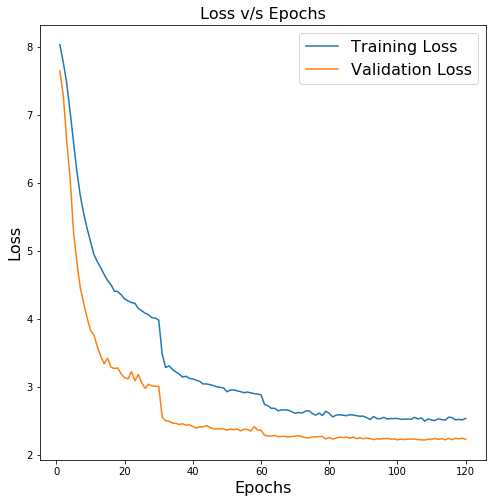

In [19]:
plt.figure(figsize=(8,8))
x = np.arange(1,121)
plt.plot(x, train_loss, label = 'Training Loss')
plt.plot(x, v_loss, label = 'Validation Loss')
plt.xlabel('Epochs', fontsize =16)
plt.ylabel('Loss', fontsize =16)
plt.title('Loss v/s Epochs',fontsize =16)
plt.legend(fontsize=16)

Text(0.5, 1.0, 'Validation Accuracy v/s Epochs')

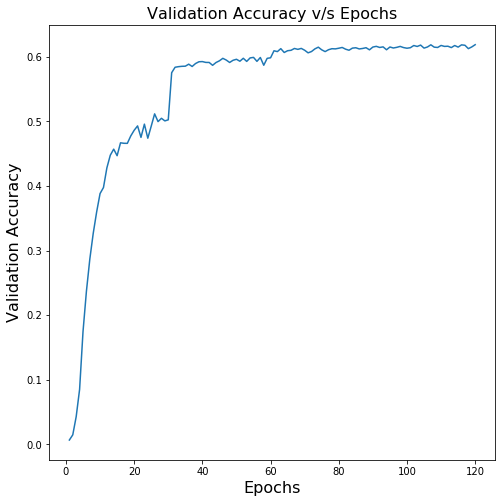

In [20]:
plt.figure(figsize=(8,8))
x = np.arange(1,121)
plt.plot(x, v_acc)
plt.xlabel('Epochs', fontsize =16)
plt.ylabel('Validation Accuracy', fontsize =16)
plt.title('Validation Accuracy v/s Epochs',fontsize =16)


In [18]:
t_loss,top1_t_acc, top5_t_acc =test_classify(model, train_dataloader)
print('Training Loss: {:.4f}\tTop 1 Training Accuracy: {:.4f}\t Top 5 Training Accuracy: {:.4f}'.format(t_loss, top1_t_acc, top5_t_acc))

Training Loss: 1.7100	Top 1 Training Accuracy: 0.6741	 Top 5 Training Accuracy: 0.8681


In [17]:
v_loss, top1_acc, top5_acc = test_classify(model, validation_dataloader)
print('Validation Loss: {:.4f}\tTop 1 Validation Accuracy: {:.4f}\t Top 5 Validation Accuracy: {:.4f}'.format(v_loss, top1_acc, top5_acc))

Validation Loss: 2.5966	Top 1 Validation Accuracy: 0.5975	 Top 5 Validation Accuracy: 0.7694


In [11]:
# class RingLoss(nn.Module):
#     """
#     Refer to paper
#     Ring loss: Convex Feature Normalization for Face Recognition
#     """
#     def __init__(self, type='L2', loss_weight=1.0):
#         super(RingLoss, self).__init__()
#         self.radius = nn.Parameter(torch.Tensor(1))
#         self.radius.data.fill_(-1)
#         self.loss_weight = loss_weight
#         self.type = type
#     def forward(self, x):
# #         x = x.pow(2).sum(dim=1).pow(0.5)
#         x = x - x.mean(1, keepdims=True).detach()
#         featnorm = x.norm(dim=1)
#         if self.radius.data[0] < 0: # Initialize the radius with the mean feature norm of first iteration
#             self.radius.data.fill_(x.mean().item())
            
#         diff = (featnorm - self.radius) / (featnorm.mean().detach().clamp(min=0.5))
#         diff_sq = torch.pow(torch.abs(diff), 2).mean()
#         ringloss = diff_sq.mul_(self.loss_weight)
       
#         return ringloss

In [11]:
# import torch
# from torch.nn.parameter import Parameter
# from .loss_base import LossFunc

# param_default = {'update_radius': True, 'loss_weight': 1.0}

# class RingLoss(LossFunc):
#     def __init__(self, **loss_info): # e.g. loss_info = {'loss_weight': 1.0}
#         super(RingLoss, self).__init__()
#         final_info = {}
#         final_info.update(param_default)
#         final_info.update(loss_info)
#         self.update_radius = final_info['update_radius']
#         if self.update_radius:
#             self.radius = Parameter(torch.Tensor(1))
#             self.radius.data.fill_(-1)
#         else:
#             self.register_buffer('radius', torch.zeros(1))
#         self.loss_weight = final_info['loss_weight']

#     def forward(self, feat, **kwargs):
#         feat = feat - feat.mean(1, keepdims=True).detach()
#         featnorm = feat.norm(dim=1)
#         if self.radius.item() < 0 or not self.update_radius:
#             self.radius.data.fill_(featnorm.mean().item())
#         diff = (featnorm - self.radius) / (featnorm.mean().detach().clamp(min=0.5))
#         diff_sq = self.sanity_check(torch.pow(torch.abs(diff), 2))
#         self.opt_out = dict(radius = self.radius.item())

#         return diff_sq.mul(self.loss_weight)